In [1]:
import open3d as o3d
import numpy as np
import matplotlib.image as mpimg
import re
from matplotlib import pyplot as plt
import json
import cv2

o3d.t.io.RealSenseSensor.list_devices()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] [0] Intel RealSense D435: 051122073420
[Open3D INFO] 	depth_fps: [100 | 15 | 30 | 300 | 6 | 60 | 90]
[Open3D INFO] 	depth_resolution: [1280,720 | 256,144 | 424,240 | 480,270 | 640,360 | 640,480 | 848,100 | 848,480]
[Open3D INFO] 	depth_format: [RS2_FORMAT_Z16]
[Open3D INFO] 	color_fps: [15 | 30 | 6 | 60]
[Open3D INFO] 	visual_preset: []
[Open3D INFO] 	color_resolution: [1280,720 | 1920,1080 | 320,180 | 320,240 | 424,240 | 640,360 | 640,480 | 848,480 | 960,540]
[Open3D INFO] 	color_format: [RS2_FORMAT_BGR8 | RS2_FORMAT_BGRA8 | RS2_FORMAT_RGB8 | RS2_FORMAT_RGBA8 | RS2_FORMAT_Y16 | RS2_FORMAT_YUYV]
[Open3D INFO] Open3D only supports synchronized color and depth capture (color_fps = depth_fps).


True

In [2]:
string = '''{"serial": "", "color_format": "RS2_FORMAT_RGB8", "color_resolution": "640,480",
             "depth_format": "RS2_FORMAT_Z16", "depth_resolution": "640,480", "fps": "30", "visual_preset": ""}'''
dicta = json.loads(string)
print(dicta)

rs_cfg = o3d.t.io.RealSenseSensorConfig(dicta)
rs = o3d.t.io.RealSenseSensor()
rs.init_sensor(rs_cfg, 0)

{'serial': '', 'color_format': 'RS2_FORMAT_RGB8', 'color_resolution': '640,480', 'depth_format': 'RS2_FORMAT_Z16', 'depth_resolution': '640,480', 'fps': '30', 'visual_preset': ''}


True

In [3]:
rs.start_capture(True)  # true: start recording with capture
for fid in range(1):
    im_rgbd = rs.capture_frame(True, False)  # wait for frames and align them
    # process im_rgbd.depth and im_rgbd.color
rs.stop_capture()
print(im_rgbd)

[Open3D INFO] Capture started with RealSense camera 051122073420
[Open3D INFO] Capture stopped.
RGBD Image pair [Aligned]
Color [size=(640,480), channels=3, format=UInt8, device=CPU:0]
Depth [size=(640,480), channels=1, format=UInt16, device=CPU:0]


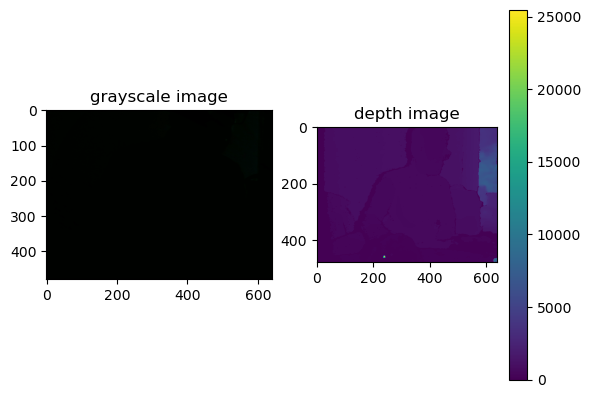

In [4]:
plt.subplot(1, 2, 1)
plt.title('grayscale image')
plt.imshow(im_rgbd.color)
plt.subplot(1, 2, 2)
plt.title('depth image')
plt.imshow(im_rgbd.depth)
plt.colorbar()
plt.show()

In [10]:
def visualize_rgbd(rgbd_image):
    print(rgbd_image)
    o3d.visualization.draw_geometries([rgbd_image])
    
    #intrinsic = o3d.camera.PinholeCameraIntrinsic()
    #intrinsic.intrinsic_matrix =  [[462.1379699707031, 0.0, 320.0], [0.0, 462.1379699707031, 240.0], [0.0, 0.0, 1.0]]
    #intrinsic.intrinsic_matrix =  [[347.99755859375, 0.0, 320.0], [0.0, 347.99755859375, 240.0], [0.0, 0.0, 1.0]]
    #intrinsic.intrinsic_matrix =  [[602.71783447, 0.0, 313.06835938], [0.0, 601.61364746, 230.37461853], [0.0, 0.0, 1.0]]
    w = 640
    h = 480
    fx = 602.71783447
    fy = 601.61364746
    cx = 313.06835938
    cy = 230.37461853
    
    intrinsic = o3d.camera.PinholeCameraIntrinsic(w, h, fx,fy, cx, cy)
    intrinsic.intrinsic_matrix = [[fx, 0, cx], [0, fy, cy], [0, 0, 1]]
    
    cam = o3d.camera.PinholeCameraParameters()
    cam.intrinsic = intrinsic
    
    #cam.extrinsic = np.array([[0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 1.]])
    #pcd = o3d.geometry.create_point_cloud_from_rgbd_image(rgbd_image, cam.intrinsic, cam.extrinsic)
    
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, cam.intrinsic)
    #pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image,intrinsic)
    
    pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down.
    
    o3d.visualization.draw_geometries([pcd])
    
    return pcd
    
    
def tst_dataset(im_rgbd):
    color_raw = o3d.geometry.Image(np.asarray(im_rgbd.color))
    depth_raw = o3d.geometry.Image(np.asarray(im_rgbd.depth))
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, convert_rgb_to_intensity=False)
    pcd = visualize_rgbd(rgbd_image)
    return pcd

pt_cloud = tst_dataset(im_rgbd)

RGBDImage of size 
Color image : 640x480, with 3 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


In [6]:
downpcd = pt_cloud.voxel_down_sample(voxel_size=0.05)
o3d.visualization.draw_geometries([downpcd])

In [7]:
#pt_cloud.estimate_normals(,search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=4, max_nn=300), fast_normal_computation=True)

print("Recompute the normal of the downsampled point cloud")
downpcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30)) #radius in meters

o3d.visualization.draw_geometries([downpcd], point_show_normal=True)

Recompute the normal of the downsampled point cloud


In [8]:
print("Align normals towards camera") #orient_normals_towards_camera_location(self, camera_location=array([0.0, 0.0, 0.0]))

downpcd.orient_normals_towards_camera_location()

o3d.visualization.draw_geometries([downpcd], point_show_normal=True)

Align normals towards camera


In [11]:
print("Align normals towards tangent plane") 

downpcd.orient_normals_consistent_tangent_plane(10)
o3d.visualization.draw_geometries([downpcd], point_show_normal=True)

Align normals towards tangent plane


http://www.open3d.org/docs/release/python_api/open3d.geometry.PointCloud.html#open3d.geometry.PointCloud.detect_planar_patches

In [12]:
print("Fetch Specific points in pointCloud and returns another pointCloud")

zz=downpcd.select_by_index([1,2,3,4,5,6,7,8,9,100,1000], invert=False)
o3d.visualization.draw_geometries([zz], point_show_normal=True)

Fetch Specific points in pointCloud and returns another pointCloud


In [13]:
zz

PointCloud with 10 points.

In [14]:
print("Fetch normals of each point in pointCloud")
np.asarray(zz.normals)

Fetch normals of each point in pointCloud


array([[ 0.27724621, -0.9606088 ,  0.01911199],
       [-0.01919174, -0.96707257,  0.25377611],
       [-0.09331524, -0.956285  ,  0.27714845],
       [-0.13581512, -0.96334547,  0.23134339],
       [-0.0125844 , -0.97481804,  0.22264643],
       [ 0.27724621, -0.9606088 ,  0.01911199],
       [ 0.31600715, -0.93143427, -0.18047073],
       [-0.        , -0.        , -1.        ],
       [ 0.3717502 , -0.8810701 , -0.29243335],
       [-0.15516886, -0.98776361, -0.01567404]])

In [15]:
print("Fetch Points in pointCloud")
np.asarray(zz.points)

Fetch Points in pointCloud


array([[-0.10228372, -0.13164057, -0.36899999],
       [ 0.10283059, -0.07761197, -0.21606   ],
       [ 0.03496431, -0.09203921, -0.2437737 ],
       [ 0.04109923, -0.09218079, -0.27116902],
       [-0.04002186, -0.07310099, -0.2214353 ],
       [-0.10546943, -0.12402911, -0.37416907],
       [-0.09910053, -0.12412766, -0.38232155],
       [ 0.36847408, -0.21675816, -0.7131923 ],
       [-0.13721468, -0.11625519, -0.36323909],
       [ 1.13828418, -0.32589257, -2.48975   ]])

In [16]:
print("Fetch Colors of each point in pointCloud")
np.asarray(zz.colors)

Fetch Colors of each point in pointCloud


array([[0.        , 0.00784314, 0.        ],
       [0.        , 0.00784314, 0.        ],
       [0.        , 0.00784626, 0.        ],
       [0.        , 0.00789837, 0.        ],
       [0.        , 0.00784314, 0.        ],
       [0.        , 0.00784314, 0.        ],
       [0.        , 0.00784314, 0.        ],
       [0.        , 0.00784314, 0.        ],
       [0.        , 0.00784314, 0.        ],
       [0.        , 0.00784314, 0.        ]])